### 基于Python逐行代码详解脑电反向编码模型(Inverted Encoding Model, IEM)

作者：路子童（Twitter: @ZitongLu; GitHub: @ZitongLu1996; 公众号: 路同学）

### 关于IEM

**反向编码模型（inverted encoding model, IEM）**是一种编码+解码模型，其通过一个编码模型基于训练数据拟合得到权重，再将该权重应用于一个解码模型基于测试数据得到解码结果。相较于基于分类的解码（classification-based decoding）和表征相似性分析（representational similarity analysis, RSA）。  
IEM基于单个单元对刺激空间的生理响应特性设计，其编码模型（输入刺激->大脑活动的模型）与解码模型（大脑活动->输入刺激的模型）相互可转化，可应用于广泛的刺激（如光栅、颜色、声学特征、面孔等等），同时IEM通过产生整个刺激空间的活动度量，其解码模型可以预测与重构训练中没有使用过的新刺激或新的实验条件，可以提供超越基于分类的解码的解释优势。

### 示例数据

原数据集基于Bae&Luck2019年发表在Journal of Neuroscience上的文章《Dissociable Decoding of Spatial Attention and Working Memory from EEG Oscillations and Sustained Potentials》实验2的数据
这是一个视觉工作记忆任务，被试要求记忆一个水滴形状的朝向，刺激呈现200ms  
经过1300毫秒的延迟后呈现一个随机朝向的水滴形状，被试需要转动鼠标使朝向尽可能和记忆朝向一致  
刺激可能有16种不同的朝向以及16种不同的位置  
这里仅提取前5个被试的数据，数据为做过预处理并分好段之后的ERP数据（预处理参数见论文原文）并带有每一个试次的朝向和位置标签  
下载链接：  
链接:https://pan.baidu.com/s/1g_qCILBrEF0P-uuOf6yBRA 密码:ulia  
解压后，'demo_data2'文件夹下包含两个文件夹：'data'和'labels'  
在'data'文件夹下包含5个被试的脑电数据.mat文件，在'labels'文件夹下包含每个被试所有试次对应刺激项的朝向标签文件和位置标签文件  
以被试编号'201'为例，'ori_201.txt'文件包含其每一个试次的记忆项的朝向信息，'pos_201.txt'文件包含其每一个试次的记忆项的位置信息  
数据中，导联数为27，采样率为250Hz，从刺激呈现前1.5s到刺激呈现后1.5s，每个试次包含750个时间点

导入必要的packages

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split, StratifiedKFold
from neurora.rsa_plot import plot_tbyt_decoding_acc

/Users/zitonglu/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


批处理读取数据

In [2]:
# 5个被试的编号
sub_ids = ['201', '202', '203', '204', '205']

# 初始化三个变量data、label_ori和label_pos
# 分别用于后续存储脑电数据、朝向的标签和位置的标签
data = np.zeros([5, 640, 27, 500])
label_ori = np.zeros([5, 640])
label_pos = np.zeros([5, 640])

# 对5个被试的数据进行遍历
for i, sub in enumerate(sub_ids):
    
    # 每个被试ERP数据、记忆项朝向标签和记忆项位置标签的文件地址
    subdata_path = 'demo_data2/data/ERP' + sub + '.mat'
    suborilabels_path = 'demo_data2/labels/ori_' + sub + '.txt'
    subposlabels_path = 'demo_data2/labels/pos_' + sub + '.txt'
    
    # 读取ERP数据(取-0.5s到1.5s的数据)
    data[i] = sio.loadmat(subdata_path)['filtData'][:, :, 250:]
    # 读取记忆项的朝向和位置的标签
    # 在.txt文件里，第一列为具体的朝向/位置值，第二列为16个朝向/位置对应的标签值（0-15的整数表示）
    label_ori[i] = np.loadtxt(suborilabels_path)[:, 1]
    label_pos[i] = np.loadtxt(subposlabels_path)[:, 1]

### 以第一个被试第0.5s的数据为例进行基于Position的IEM分析

以第一个被试（编号’201‘）的数据为例  
打印其前10个试次的Labels:

In [3]:
print('Position Labels:')
print(label_pos[0, :10])

Position Labels:
[12. 10. 13. 10.  8.  1. 14.  4.  3.  1.]


上述标签0到15分别依次对应0°到337.5°（间隔22.5°）

可视化该被试前10个试次第250个时间点（对应0.5s时刻）的数据：

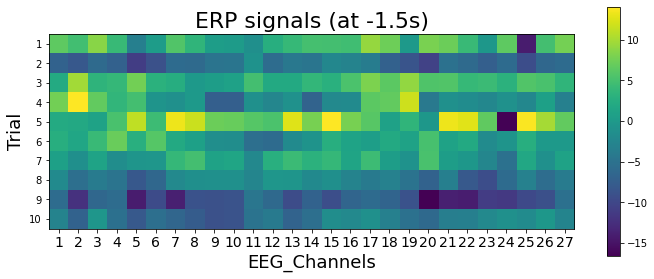

In [4]:
plt.imshow(data[0, :10, :, 250])
plt.xticks(np.arange(27), np.arange(27)+1, fontsize=14)
plt.yticks(np.arange(10), np.arange(10)+1)
plt.ylabel("Trial", fontsize=18)
plt.xlabel("EEG_Channels", fontsize=18)
plt.title("ERP signals (at -1.5s)", fontsize=22)
fig = plt.gcf()
fig.set_size_inches(10, 4)
plt.colorbar()
plt.tight_layout();
plt.show()

这里随机抽取80%的试次作为训练数据，20%的试次作为测试数据

In [5]:
train_data, test_data, train_pos_labels, test_pos_labels = \
    train_test_split(data[0, :, :, 250], label_pos[0], test_size=0.2)

构造**编码模型（Encoding Model）**

首先需要构造不同朝向下的响应曲线  
这里构建9个Ori_Channels对应9个朝向（对应下图虚线，0°到320°，间隔40°）  
这个基础响应集（Basis set）如下：

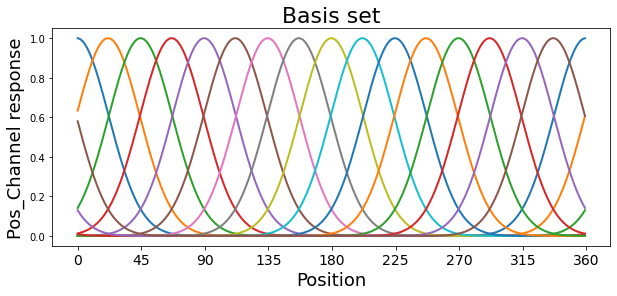

In [6]:
# 构造tuning函数
def make_gaussian_iter(mu,sd):
    return np.array([np.roll(signal.gaussian(360, std=s), m-180) for m,s in zip(mu,sd)]).T
basis_points = np.linspace(0, 360-360/16, 16).astype(np.int)
basis_set = make_gaussian_iter(basis_points, np.ones(16)*22.5)
plt.plot(basis_set,lw=2)
plt.xlabel("Position", fontsize=18)
plt.ylabel("Pos_Channel response", fontsize=18)
plt.xticks([0, 45, 90, 135, 180, 225, 270, 315, 360], fontsize=14)
plt.title("Basis set", fontsize=22)
fig = plt.gcf()
fig.set_size_inches(10, 4)
plt.show()

因此基于每一个试次的Label，可以构造出每一个试次对应朝向下（来自训练数据）的理想响应情况  
即将每个试次的朝向数据传入Basis set得到对应的每个Pos_Channel的响应  
(这里由于生产的Basis set是基于整数点的，因此将22.5°近似取整为23°，其他角度类推)  
这里绘制前10个试次的响应情况：

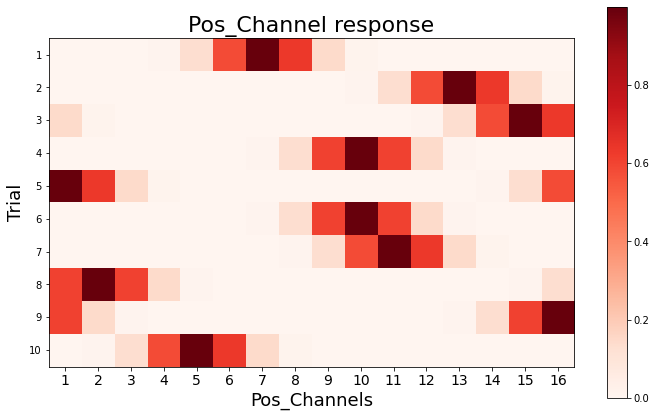

In [7]:
responses = basis_set[np.array((train_pos_labels)*22.5, dtype=np.int), :]
# shape of response: [n_trials, n_pos_channels] = [576, 16]
plt.imshow(responses[:10], cmap='Reds')
plt.xticks(np.arange(16), np.arange(16)+1, fontsize=14)
plt.yticks(np.arange(10), np.arange(10)+1)
plt.ylabel("Trial", fontsize=18)
plt.xlabel("Pos_Channels", fontsize=18)
plt.title("Pos_Channel response", fontsize=22)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.colorbar()
plt.tight_layout();
plt.show()

**编码模型（Encoding Model）**为：Responses * Weights = Trained_EEG_Signals  
这里，三个矩阵的形状依次为：  
Responses: N_Trials * N_Pos_Channels  
Weights: N_Pos_Channels * N_EEG_Channels  
Trained_EEG_Signals: N_Trials * N_EEG_Channels

因此，我们需要使用训练数据拟合得到Weight  
这里使用线性回归的方法计算Weight并可视化

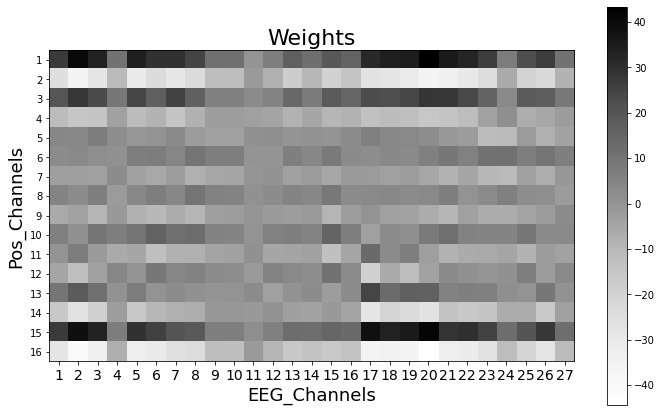

In [8]:
weights = np.linalg.lstsq(responses, train_data, rcond=None)[0]
# shape of weight: [n_pos_channels, n_EEG_channels] = [16, 27]
plt.imshow(weights, cmap='Greys')
plt.xticks(np.arange(27), np.arange(27)+1, fontsize=14)
plt.yticks(np.arange(16), np.arange(16)+1)
plt.ylabel("Pos_Channels", fontsize=18)
plt.xlabel("EEG_Channels", fontsize=18)
plt.title("Weights", fontsize=22)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.colorbar()
plt.tight_layout();
plt.show()

使用**解码模型（Decoding Model）**对测试数据进行重构  
**解码模型（Decoding Model）**为：Reconstructions * Weights = Test_EEG_Signals   
这里，三个矩阵的形状依次为：  
Reconstructions: N_Trials * N_Pos_Channels  
Weights: N_Pos_Channels * N_EEG_Channels  
Test_EEG_Signals: N_Trials * N_EEG_Channels

因此使用线性回归的方法获取Reconstructions并可视化前10个试次的重构结果

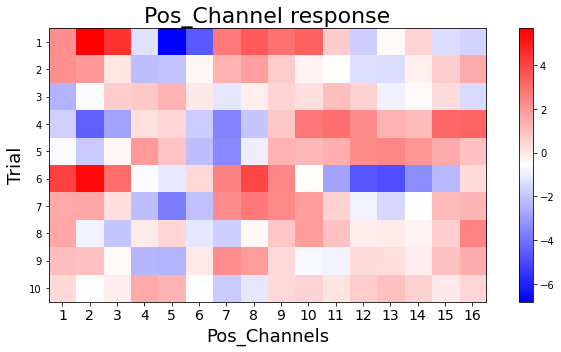

In [9]:
reconstructions = np.linalg.lstsq(weights.T, test_data.T, rcond=None)[0].T
# shape of reconstruction: [n_trials, n_pos_channels] = [64, 16]
plt.imshow(reconstructions[:10], cmap='bwr')
plt.xticks(np.arange(16), np.arange(16)+1, fontsize=14)
plt.yticks(np.arange(10), np.arange(10)+1)
plt.ylabel("Trial", fontsize=18)
plt.xlabel("Pos_Channels", fontsize=18)
plt.title("Pos_Channel response", fontsize=22)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.colorbar()
plt.tight_layout();
plt.show()

将重构的结果调整到相对该试次对应朝向的错误朝向的空间上  
即对应到与正确朝向相差的-180°到180°的空间上

In [10]:
aligned_reconstruction = np.zeros([128, 17])
for i in range(128):
    aligned_reconstruction[i, 1:] = np.roll(reconstructions[i, :], 7 - int(test_pos_labels[i]))
aligned_reconstruction[:, 0] = aligned_reconstruction[:, -1]

对重构结果平均并可视化

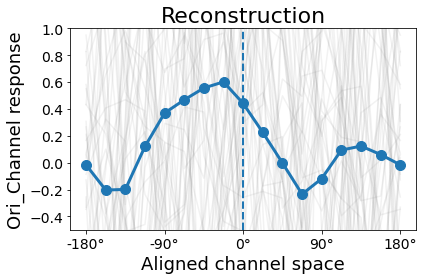

In [11]:
for i in range(64):
    plt.plot(np.arange(17), aligned_reconstruction[i], color='grey', alpha=0.1)
plt.plot(np.arange(17), np.average(aligned_reconstruction, axis=0),
         marker='o', markersize=10, lw=3)
plt.axvline(8, ls='--', lw=2)
plt.xticks([0, 4, 8, 12, 16], ['-180°', '-90°', '0°', '90°', '180°'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Ori_Channel response", fontsize=18)
plt.xlabel("Aligned channel space", fontsize=18)
plt.title("Reconstruction", fontsize=22)
plt.ylim(-0.5, 1)
plt.tight_layout();
plt.show()

计算0° error处的slope:  

In [12]:
print('slope:', np.average(aligned_reconstruction, axis=0)[8])

slope: 0.44089884419258757


实际计算中需要多次随机打乱抽取训练数据与测试数据

### 多被试时序IEM分析

上述示例已经详细说明了针对单个被试单个时间点使用IEM对某一特征的解码过程  
现拓展至多被试多时间点  
同时，这里采用5次5折的方法进行IEM分析  
最终目的是获取每一个被试在每一个时间点上重构出来的Tuning curve的slope

首先对Position进行IEM分析

In [13]:
# 定义变量存储IEM重构结果
IEMresults = np.zeros([5, 500, 17])

# 对被试进行迭代
for subi in range(5):          
                
    print("计算中...")
    
    # 对时间点进行迭代
    for t in range(500):  
        
        # 该被试该时间点下的数据
        # 其shape为: [640, 27]
        data_subi_t = data[subi, :, :, t]
        # 对应的position的标签
        # 其shape为: [640]
        labels_subi_t = label_pos[subi]
        
        # 定义一个变量存储该被试该时间点5次5折的重构结果
        IEMresults_subi_t = np.zeros([5, 5, 17])
        
        # 5次5折
        # 随机5次，对每一次迭代
        for k in range(5):
            
            # 随机一个种子
            state = np.random.randint(0, 100)
            # 生成10折
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
            
            fold_index = 0 # 用于记录第几个fold
            # 对每一折迭代
            for train_index, test_index in kf.split(data_subi_t, labels_subi_t):
                
                # 获取每一折的训练数据、测试数据、训练标签和测试标签
                train_data = data_subi_t[train_index]
                test_data = data_subi_t[test_index]
                train_labels = labels_subi_t[train_index]
                test_labels = labels_subi_t[test_index]
                
                # Encoding Model
                # 计算Response
                responses = basis_set[np.array((train_labels)*22.5, dtype=np.int), :]
                # 计算Weights
                weights = np.linalg.lstsq(responses, train_data, rcond=None)[0]
                
                # Decoding Model
                # 重构
                reconstructions = np.linalg.lstsq(weights.T, test_data.T, rcond=None)[0].T
                
                # 定义变量存储每个test trials的slopes
                aligned_reconstruction = np.zeros([len(test_labels), 17])
                for i in range(len(test_labels)):
                    aligned_reconstruction[i, 1:] = \
                        np.roll(reconstructions[i, :], 7 - int(test_labels[i]))
                aligned_reconstruction[:, 0] = aligned_reconstruction[:, -1]
                
                IEMresults_subi_t[k, fold_index] = np.average(aligned_reconstruction, axis=0)
                
                fold_index = fold_index + 1
                
        IEMresults[subi, t] = np.average(IEMresults_subi_t, axis=(0, 1))
        
    print("第" + str(subi+1) + "个被试计算完成!")

计算中...
第1个被试计算完成!
计算中...
第2个被试计算完成!
计算中...
第3个被试计算完成!
计算中...
第4个被试计算完成!
计算中...
第5个被试计算完成!


可视化重构出的tuning curves  
这里选取t=-0.5s, 0s, 0.5s, 1s四个时间绘图

(5, 500, 17)
250
(5, 17)


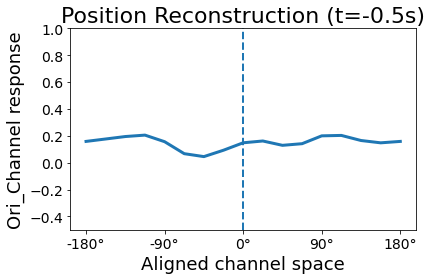

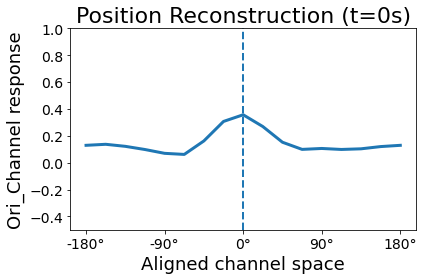

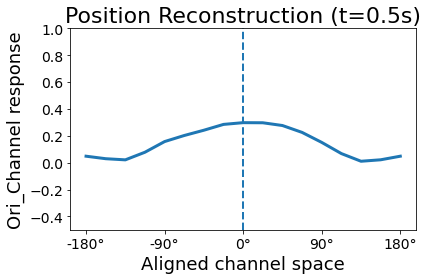

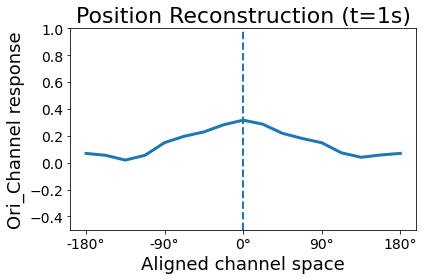

In [14]:
t_tindexes = [0, 125, 250, 375]
t_titles = ['-0.5s', '0s', '0.5s', '1s']

print(IEMresults.shape)
print(int(t_tindexes[2]))
print(IEMresults[:, int(t_tindexes[2])].shape)

for i in range(4):
    IEMresults_t = IEMresults[:, int(t_tindexes[i])]
    plt.plot(np.arange(17), np.average(IEMresults_t, axis=0), lw=3)
    plt.axvline(8, ls='--', lw=2)
    plt.xticks([0, 4, 8, 12, 16], ['-180°', '-90°', '0°', '90°', '180°'], fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Ori_Channel response", fontsize=18)
    plt.xlabel("Aligned channel space", fontsize=18)
    plt.title("Position Reconstruction (t=" + t_titles[i] + ')', fontsize=22)
    plt.ylim(-0.5, 1)
    plt.tight_layout();
    plt.show()

绘制逐时间点的被试平均重构结果

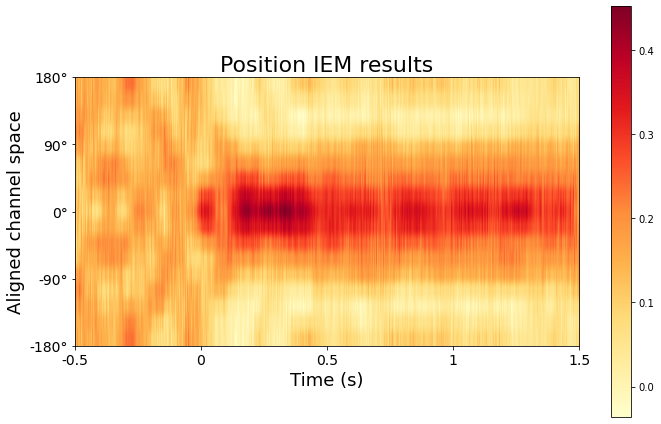

In [15]:
avgsubs_IEMresults = np.average(IEMresults, axis=0)
avgsubs_IEMresults = np.transpose(avgsubs_IEMresults, (1, 0))
plt.imshow(avgsubs_IEMresults, extent=(-0.5*15, 1.5*15, 0, 16), cmap='YlOrRd')
plt.xticks([-0.5*15, 0, 0.5*15, 1*15, 1.5*15], ['-0.5', '0', '0.5', '1', '1.5'], fontsize=14)
plt.yticks([0, 4, 8, 12, 16], ['-180°', '-90°', '0°', '90°', '180°'], fontsize=14)
plt.ylabel("Aligned channel space", fontsize=18)
plt.xlabel("Time (s)", fontsize=18)
plt.title("Position IEM results", fontsize=22)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.colorbar()
plt.tight_layout();
plt.show()

绘制slopes的时序曲线图

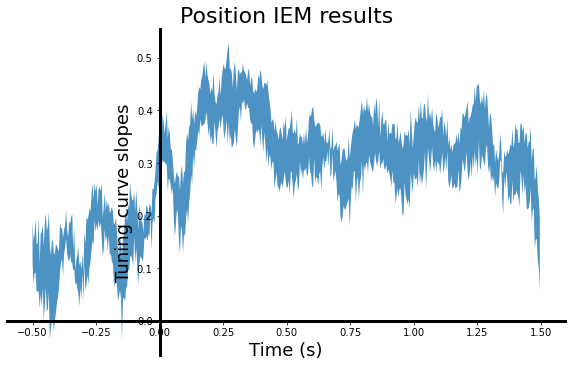

In [16]:
slopes = IEMresults[:, :, 8]
avg_slopes = np.average(slopes, axis=0)
err_slopes = np.zeros([500])
for t in range(500):
    err_slopes[t] = np.std(slopes[:, t], ddof=1)/np.sqrt(5)
plt.fill_between(np.arange(-0.5, 1.5, 0.004), avg_slopes+err_slopes, avg_slopes-err_slopes,
                alpha=0.8)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_linewidth(3)
ax.spines['bottom'].set_position(('data', 0))
plt.ylabel("Tuning curve slopes", fontsize=18)
plt.xlabel("Time (s)", fontsize=18)
plt.title("Position IEM results", fontsize=22)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.show()

同理，对于Orientation

计算中...
第1个被试计算完成!
计算中...
第2个被试计算完成!
计算中...
第3个被试计算完成!
计算中...
第4个被试计算完成!
计算中...
第5个被试计算完成!
(5, 500, 17)
250
(5, 17)


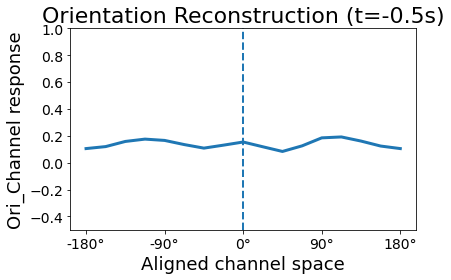

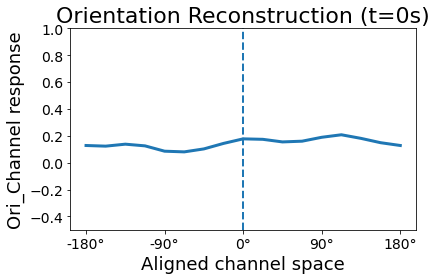

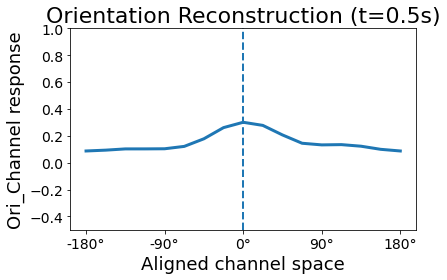

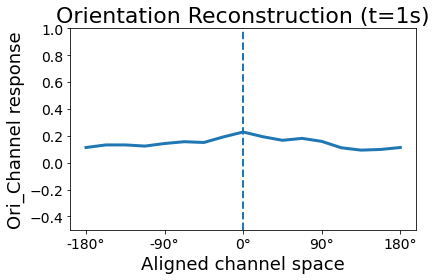

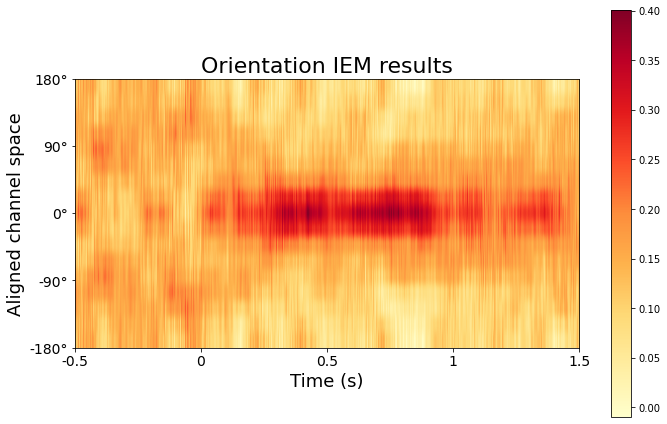

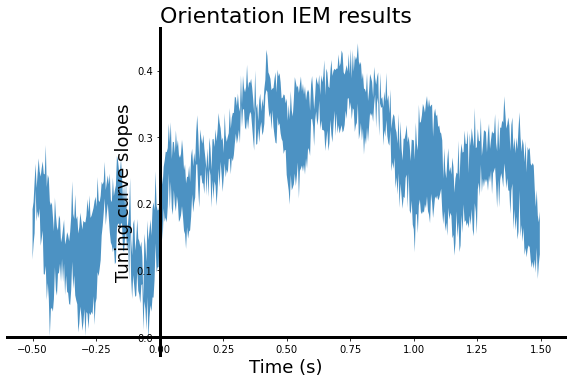

In [17]:
# 定义变量存储IEM重构结果
IEMresults = np.zeros([5, 500, 17])

# 对被试进行迭代
for subi in range(5):          
                
    print("计算中...")
    
    # 对时间点进行迭代
    for t in range(500):  
        
        # 该被试该时间点下的数据
        # 其shape为: [640, 27]
        data_subi_t = data[subi, :, :, t]
        # 对应的position的标签
        # 其shape为: [640]
        labels_subi_t = label_ori[subi]
        
        # 定义一个变量存储该被试该时间点5次5折的重构结果
        IEMresults_subi_t = np.zeros([5, 5, 17])
        
        # 5次5折
        # 随机5次，对每一次迭代
        for k in range(5):
            
            # 随机一个种子
            state = np.random.randint(0, 100)
            # 生成10折
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
            
            fold_index = 0 # 用于记录第几个fold
            # 对每一折迭代
            for train_index, test_index in kf.split(data_subi_t, labels_subi_t):
                
                # 获取每一折的训练数据、测试数据、训练标签和测试标签
                train_data = data_subi_t[train_index]
                test_data = data_subi_t[test_index]
                train_labels = labels_subi_t[train_index]
                test_labels = labels_subi_t[test_index]
                
                # Encoding Model
                # 计算Response
                responses = basis_set[np.array((train_labels)*22.5, dtype=np.int), :]
                # 计算Weights
                weights = np.linalg.lstsq(responses, train_data, rcond=None)[0]
                
                # Decoding Model
                # 重构
                reconstructions = np.linalg.lstsq(weights.T, test_data.T, rcond=None)[0].T
                
                # 定义变量存储每个test trials的slopes
                aligned_reconstruction = np.zeros([len(test_labels), 17])
                for i in range(len(test_labels)):
                    aligned_reconstruction[i, 1:] = \
                        np.roll(reconstructions[i, :], 7 - int(test_labels[i]))
                aligned_reconstruction[:, 0] = aligned_reconstruction[:, -1]
                
                IEMresults_subi_t[k, fold_index] = np.average(aligned_reconstruction, axis=0)
                
                fold_index = fold_index + 1
                
        IEMresults[subi, t] = np.average(IEMresults_subi_t, axis=(0, 1))
        
    print("第" + str(subi+1) + "个被试计算完成!")

t_tindexes = [0, 125, 250, 375]
t_titles = ['-0.5s', '0s', '0.5s', '1s']

print(IEMresults.shape)
print(int(t_tindexes[2]))
print(IEMresults[:, int(t_tindexes[2])].shape)

for i in range(4):
    IEMresults_t = IEMresults[:, int(t_tindexes[i])]
    plt.plot(np.arange(17), np.average(IEMresults_t, axis=0), lw=3)
    plt.axvline(8, ls='--', lw=2)
    plt.xticks([0, 4, 8, 12, 16], ['-180°', '-90°', '0°', '90°', '180°'], fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Ori_Channel response", fontsize=18)
    plt.xlabel("Aligned channel space", fontsize=18)
    plt.title("Orientation Reconstruction (t=" + t_titles[i] + ')', fontsize=22)
    plt.ylim(-0.5, 1)
    plt.tight_layout();
    plt.show()

avgsubs_IEMresults = np.average(IEMresults, axis=0)
avgsubs_IEMresults = np.transpose(avgsubs_IEMresults, (1, 0))
plt.imshow(avgsubs_IEMresults, extent=(-0.5*15, 1.5*15, 0, 16), cmap='YlOrRd')
plt.xticks([-0.5*15, 0, 0.5*15, 1*15, 1.5*15], ['-0.5', '0', '0.5', '1', '1.5'], fontsize=14)
plt.yticks([0, 4, 8, 12, 16], ['-180°', '-90°', '0°', '90°', '180°'], fontsize=14)
plt.ylabel("Aligned channel space", fontsize=18)
plt.xlabel("Time (s)", fontsize=18)
plt.title("Orientation IEM results", fontsize=22)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.colorbar()
plt.tight_layout();
plt.show()

slopes = IEMresults[:, :, 8]
avg_slopes = np.average(slopes, axis=0)
err_slopes = np.zeros([500])
for t in range(500):
    err_slopes[t] = np.std(slopes[:, t], ddof=1)/np.sqrt(5)
plt.fill_between(np.arange(-0.5, 1.5, 0.004), avg_slopes+err_slopes, avg_slopes-err_slopes,
                alpha=0.8)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_linewidth(3)
ax.spines['bottom'].set_position(('data', 0))
plt.ylabel("Tuning curve slopes", fontsize=18)
plt.xlabel("Time (s)", fontsize=18)
plt.title("Orientation IEM results", fontsize=22)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.show()

参考：  
Scotti, P.S., Chen, J. & Golomb, J.D. (2021). An enhanced inverted encoding model for neural reconstructions. Preprint.  
Sprague, T.C., Saproo, S., Serences, J.T. (2015). Visual attention mitigates information loss in small- and large-scale neural codes. Trends in Cognitive Sciences, 1-12.  
fMRI_Playground: https://github.com/PaulScotti/fmriplayground.